In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # interactive mode?

In [4]:
# data augmentation and normalization for training
# normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                            data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<class 'torch.Tensor'>


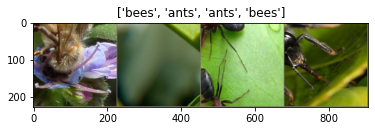

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Model Training

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

## Visualization of Model Prediction

In [41]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

            model.train(mode=was_training)

In [38]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [39]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5951 Acc: 0.6926
val Loss: 0.3419 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.5475 Acc: 0.8033
val Loss: 0.3471 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.5767 Acc: 0.7746
val Loss: 0.4247 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.4666 Acc: 0.7910
val Loss: 0.2346 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3999 Acc: 0.8320
val Loss: 0.3793 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.6478 Acc: 0.7500
val Loss: 0.7087 Acc: 0.8170

Epoch 6/24
----------
train Loss: 0.4693 Acc: 0.8156
val Loss: 0.2816 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4720 Acc: 0.8361
val Loss: 0.2428 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3453 Acc: 0.8361
val Loss: 0.2135 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3060 Acc: 0.8770
val Loss: 0.2075 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.2516 Acc: 0.8893
val Loss: 0.2082 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3076 Acc: 0.8648
val Loss: 0.2128 Acc: 0.9477

Ep

<class 'torch.Tensor'>


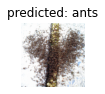

<class 'torch.Tensor'>


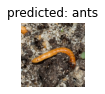

<class 'torch.Tensor'>


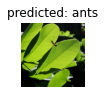

<class 'torch.Tensor'>


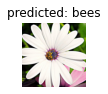

<class 'torch.Tensor'>


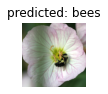

<class 'torch.Tensor'>


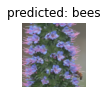

In [42]:
visualize_model(model_ft)

In [43]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 구성된 모듈에 있는 파라미터들은 requires_grad=True 가 default이다.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전 optimizer와 비교해서 마지막 레이어의 파리미터들만 최적화된다는 것을 관잘해보자.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 epochs 마다 lr에 0.1을 곱해서 사용(decay, gamma)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [44]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6573 Acc: 0.6025
val Loss: 0.5571 Acc: 0.7190

Epoch 1/24
----------
train Loss: 0.5553 Acc: 0.7746
val Loss: 0.1713 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.3664 Acc: 0.8566
val Loss: 0.1932 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4717 Acc: 0.8197
val Loss: 0.3177 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.6440 Acc: 0.7500
val Loss: 0.1996 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4516 Acc: 0.8279
val Loss: 0.1828 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3662 Acc: 0.8361
val Loss: 0.1768 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2790 Acc: 0.8811
val Loss: 0.1640 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3624 Acc: 0.8811
val Loss: 0.1649 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3636 Acc: 0.8566
val Loss: 0.1669 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2267 Acc: 0.9139
val Loss: 0.2214 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3577 Acc: 0.8566
val Loss: 0.1885 Acc: 0.9412

Ep

<class 'torch.Tensor'>


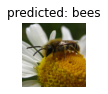

<class 'torch.Tensor'>


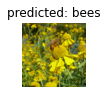

<class 'torch.Tensor'>


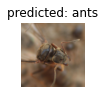

<class 'torch.Tensor'>


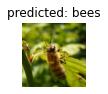

<class 'torch.Tensor'>


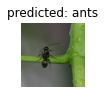

<class 'torch.Tensor'>


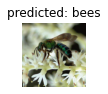

In [45]:
visualize_model(model_conv)

plt.ioff()
plt.show()